#### Adagrad

To get good accuracy we typically want to decrease the learning rate as we keep on training. Intuition is longer we are into training, we want the updates to happen slower to not overshoot the global minima.

Now algos like SGD always maintain a constant learning rate and this can be bad especially when it comes to sparse data.


What happens if we mindlessly keep lowering learning rate for the data? If your dataset is sparse or if you have sparse features, you quickly run into some problems.

Parameters associated with infrequent features only receive meaningful updates whenever these features occur. Given a decreasing learning rate we might end up in a situation where the parameters for common features converge rather quickly to their optimal values, whereas for infrequent features we are still short of observing them sufficiently frequently before their optimal values can be determined. In other words, the learning rate either decreases too slowly for frequent features or too quickly for infrequent ones.

So we want the learning rate to stay adaptive to each feature right?

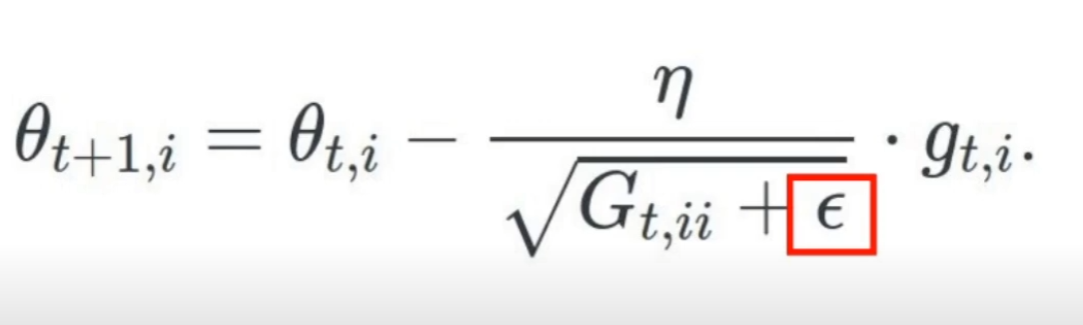

The equation is pretty much similar to SGD except with the division bit. Lets see.


- θt+1 = new parameters
- θt = previous parameters
- n = learning rate
- gt = current gradient
- Gt = accumulated gradients until timestep t(the gradients are squared btw)
- ε = small value to prevent division by 0 and underflow errors. 

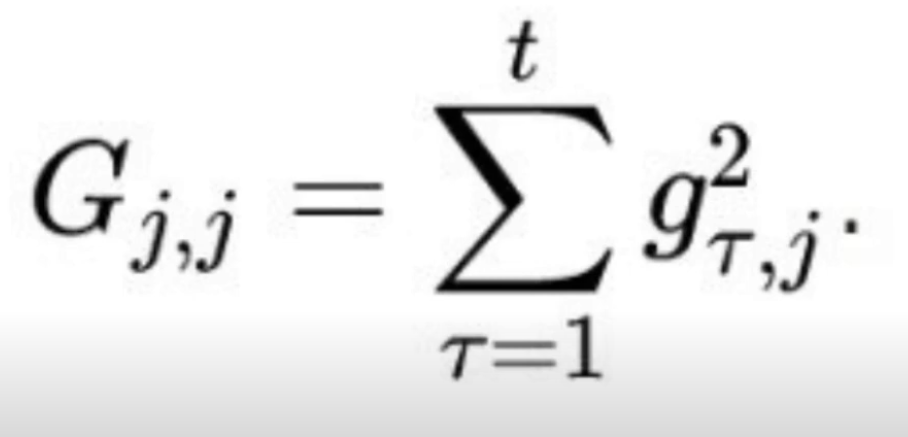

```
Intuition is -

Say we have sparse features, the Gt, accumulated gradients will be quite small right, since they appear less often. Now dividing the learning_rate by a small number means the overall term is bigger compared to dividing by a large number. The update taken becomes now larger.

The opposite for more frequent features, where Gt quite large, the learning rate becomes quite small since n/large = smaller n than n/small.
```

In [1]:
### SGD without momentum

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(2024)

# Hyperparameters
n_embd = 10
n_hidden = 64
n_classes = 10
batch_size = 64
learning_rate = 0.01
num_epochs = 10


# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='D:/advanced_ml/01-backprop-by-hand/data', train=True, download=False, transform=transform)
test_dataset = datasets.MNIST(root='D:/advanced_ml/01-backprop-by-hand/data', train=False, download=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the model
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleNet()

# Initialize weights as per your example
g = torch.Generator().manual_seed(2024)

model.fc1.weight.data = torch.randn((n_hidden, 28 * 28), generator=g) * 0.1
model.fc1.bias.data = torch.randn(n_hidden, generator=g) * 0.1

model.fc2.weight.data = torch.randn((n_classes, n_hidden), generator=g) * 0.1
model.fc2.bias.data = torch.randn(n_classes, generator=g) * 0.1

parameters = list(model.parameters())

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters(), lr = learning_rate, eps=1e-10)

train_losses = []
epoch_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_idx % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')
        
        train_losses.append(loss.item())
    
    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}')
    print("-------------------------------")

Epoch 1/10, Batch 0/938, Loss: 3.5113
Epoch 1/10, Batch 100/938, Loss: 0.3638
Epoch 1/10, Batch 200/938, Loss: 0.3509
Epoch 1/10, Batch 300/938, Loss: 0.2579
Epoch 1/10, Batch 400/938, Loss: 0.1834
Epoch 1/10, Batch 500/938, Loss: 0.1791
Epoch 1/10, Batch 600/938, Loss: 0.2444
Epoch 1/10, Batch 700/938, Loss: 0.2599
Epoch 1/10, Batch 800/938, Loss: 0.4028
Epoch 1/10, Batch 900/938, Loss: 0.2117
Epoch 1/10, Average Loss: 0.2888
-------------------------------
Epoch 2/10, Batch 0/938, Loss: 0.2334
Epoch 2/10, Batch 100/938, Loss: 0.1510
Epoch 2/10, Batch 200/938, Loss: 0.1374
Epoch 2/10, Batch 300/938, Loss: 0.1899
Epoch 2/10, Batch 400/938, Loss: 0.2196
Epoch 2/10, Batch 500/938, Loss: 0.1746
Epoch 2/10, Batch 600/938, Loss: 0.1174
Epoch 2/10, Batch 700/938, Loss: 0.0776
Epoch 2/10, Batch 800/938, Loss: 0.2690
Epoch 2/10, Batch 900/938, Loss: 0.1305
Epoch 2/10, Average Loss: 0.1724
-------------------------------
Epoch 3/10, Batch 0/938, Loss: 0.1215
Epoch 3/10, Batch 100/938, Loss: 0.2

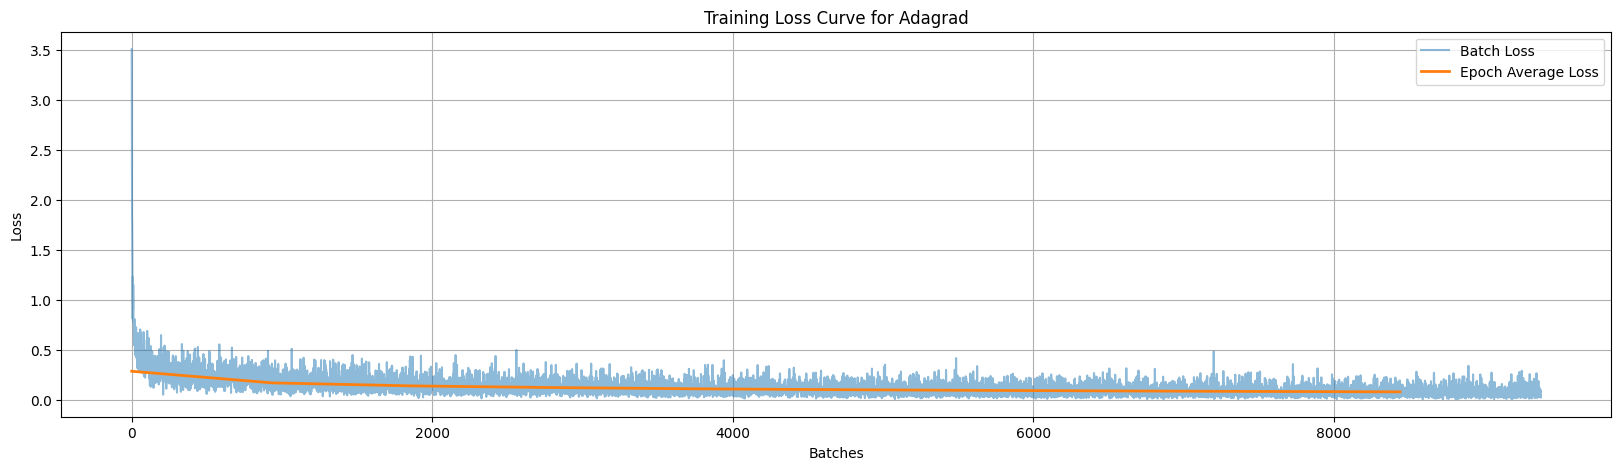

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
plt.plot(train_losses, label='Batch Loss', alpha=0.5)
plt.plot(range(0, len(train_losses), len(train_loader)), epoch_losses, label='Epoch Average Loss', linewidth=2)
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.title('Training Loss Curve for Adagrad')
plt.legend()
plt.grid(True)